# Preliminary Data Analyses

Now it's time to see how each of the predictor variables in the dataset relate to the response variable of shark density. 

In [1]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy
import statsmodels.formula.api as smf 

In [2]:
# Read in the dataset and do some quick data cleanup.
dat = pd.read_csv('D:/Documents/SpringBoard/capstone-1/datasets/final_files/combined/'
                  'filled/jackknifed_counts.csv', 
                 parse_dates=['Date']) 

dat['Receiver_D'] = dat['Receiver_D'].astype('category') # turn receiver D into a category
    # for analyses and plotting
dat['Year'] = dat['Year'].astype('category') # turn into a category
dat['Transmitter'] = pd.to_numeric(dat['Transmitter'], errors='coerce') # and make
    # sure that the 'Transmitter' (shark density) is numeric
    
dist_plot_data = dat.loc[:,:] # to plot the distributions of data next to the relationship
    # plots
    
dat = dat[dat['Transmitter'] > 0].reset_index(drop=True) # Let's remove the 0s so that we can run the analyses
    # properly.
dat['Receiver_D'] = dat['Receiver_D'].cat.remove_unused_categories()

### Shark Density vs Receiver Density

We have decided to make Receiver Density a categorical parameter so that we can see if receiver density actually significantly influences the number of sharks that are detected.

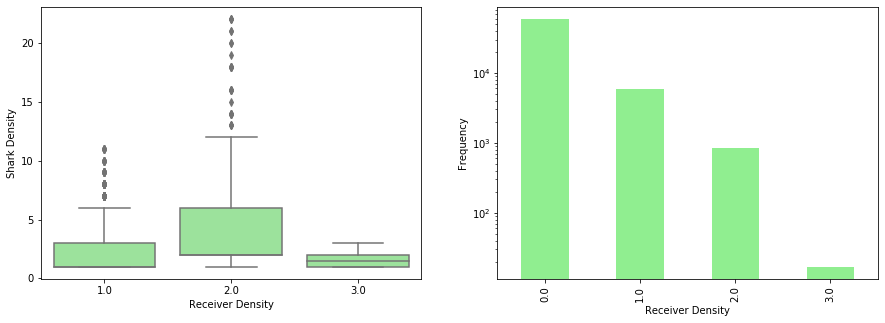

In [3]:
%matplotlib inline 

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5)) # we're going to make
    # a two panel figure so that we can display the relationship and the underlying
    # distribution of data. 
    
sns.boxplot(x='Receiver_D', y='Transmitter', data=dat, color='lightgreen', ax=ax1)
    # Let's look at the boxplot
ax1.set_xlabel('Receiver Density') # fix the x
ax1.set_ylabel('Shark Density') # fix the y

# We should also plot the distribution of receiver data for reference
r_counts = pd.DataFrame(dist_plot_data['Receiver_D'].value_counts()).reset_index()
    # get value counts for each receiver density and reset the index
r_counts.columns = ['Receiver_D', 'Frequency'] # rename the columns
r_counts.plot.bar(x='Receiver_D', y='Frequency', logy=True, color='lightgreen', 
                  legend=False, ax=ax2) # plot on the logy scale
ax2.set_xlabel('Receiver Density') # label the x
ax2.set_ylabel('Frequency') # label the y
plt.show() # show the plot

So, it looks like there's a sweet spot where more sharks are detected when 2 receivers are in the water. This is probably due to the fact that there are more instances of 2 receivers compared to 3 receivers in a zone at one time, which can be seen by the distribution plot on the right.

Let's see how these two variables interact using an ANOVA.

In [4]:
# Format data for the ANOVA.
receivers = dat.loc[:,['Receiver_D', 'Transmitter']] # only keep the relevant columns
receivers.loc[:,'intercept'] = 1 # add a null hypothesis that the intercept value is 0
receivers[['one', 'two', 'three']] = pd.get_dummies(receivers.loc[:,'Receiver_D'])
    # add a matrix of dummy values to indicate the presence of each unique
    # receiver density category

receiver_ols = sm.OLS(receivers.loc[:,'Transmitter'],receivers.loc[:,['intercept','two','three']])
    # we want to use ordinary least squares
results_receiver = receiver_ols.fit() # fit the model to the data

In [5]:
# Let's look at the results
results_receiver.summary() # get a summary of the results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transmitter   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     254.0
Date:                Mon, 16 Dec 2019   Prob (F-statistic):          1.20e-104
Time:                        10:55:37   Log-Likelihood:                -9130.6
No. Observations:                4042   AIC:                         1.827e+04
Df Residuals:                    4039   BIC:                         1.829e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1299      0.040     53.676      0.000       2.052       2.208
two            2.2694      0.101     22.524      0.000       2.072       2.467
three         -0.4632      0.947     -0.489      0.625      -2.320       1.393
==============================================================================
Omnibus:                     2197.855   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20417.982
Skew:                           2.441   Prob(JB):                         0.00
Kurtosis:                      12.869   Cond. No.                         26.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These results indicate that there is a significant differents between how many sharks are detected in a zone when 2 receivers are deployed compared to when one, or three are deployed. This is a little troubling, because it seems like the probability of a true detection might be dependent on how many receivers are in the water. Although this makes sense (more receivers in a zone likely indicate a greater % coverage within that grid cell) it introduces an artifact into our dataset. Along the same lines, we would expect to see even more sharks with 3 receivers in the water. However, the reason we don't see this relationship may be two fold: 1) The % coverage of a single grid cell may not signifcantly increase when a third receiver is added; and/or 2) There are few instances of when > 2 receivers are actually deployed within a single grid.

### Shark Density vs Year

We want to see if there's a difference in the shark density across years. Maybe some years sharks are more active than others. Perhaps they're using the southern California area every two or three years, as opposed to every year. In this case, year is also a category, so we're going to perform another ANOVA.

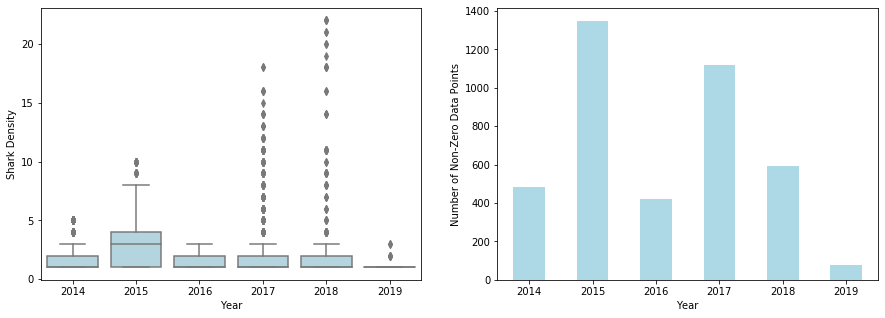

In [6]:
# First, lets plot the data.
%matplotlib inline 

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5)) # we're going to make
    # a two panel figure so that we can display the relationship and the underlying
    # distribution of data. 

sns.boxplot(x='Year', y='Transmitter', data=dat, color='lightblue', ax=ax1) # boxplot
ax1.set_xlabel('Year') # add xlabel
ax1.set_ylabel('Shark Density') # add ylabel

# Plot the distribution next to it
peryear = dist_plot_data.loc[dist_plot_data['Transmitter'] > 0, ['Transmitter','Year']].groupby('Year').agg('count')
    # count the number of transmitters > 0 each year
peryear.plot(kind='bar', legend=False, ax=ax2, rot=0, color='lightblue') # plot it
ax2.set_ylabel('Number of Non-Zero Data Points') # fix ylabel
plt.show() # show plot

From this plot, it looks like most of the years have the same IQR - except for maybe 2015. 2017 and 2018 have a lot of data outside of the IQR, but the majority of the rest of the values during these years may not be so different. Let's run an ANOVA to see.

In [7]:
yearly = dat.loc[:,['Year', 'Transmitter']] # only keep the relevant data

# Get the data ready for the anova
yearly.loc[:,'intercept'] = 1 # set the intercept to 1
yearly[['2014', '2015', '2016', '2017', '2018', '2019']] = pd.get_dummies(yearly.loc[:,'Year'])
    # and run the dummy to get a matrix for years

# Run the ANOVA
year_ols = sm.OLS(yearly.loc[:,'Transmitter'], yearly.loc[:,['intercept', '2015', 
                                                             '2016', '2017', '2018', '2019']])
    # another OLS
results_year = year_ols.fit() # fit the data

# And print out the results
results_year.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transmitter   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     45.57
Date:                Mon, 16 Dec 2019   Prob (F-statistic):           6.25e-46
Time:                        10:55:38   Log-Likelihood:                -9259.0
No. Observations:                4042   AIC:                         1.853e+04
Df Residuals:                    4036   BIC:                         1.857e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7769      0.109     16.336      0.000       1.564       1.990
2015           1.3448      0.127     10.606      0.000       1.096       1.593
2016          -0.2282      0.159     -1.431      0.153      -0.541       0.084
2017           0.7258      0.130      5.576      0.000       0.471       0.981
2018           0.6167      0.147      4.206      0.000       0.329       0.904
2019          -0.6470      0.294     -2.204      0.028      -1.223      -0.071
==============================================================================
Omnibus:                     2804.608   Durbin-Watson:                   1.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44377.750
Skew:                           3.164   Prob(JB):                         0.00
Kurtosis:                      17.948   Cond. No.                         9.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Compared to 2014, there are significantly more sharks in 2015, 2017, and 2018. In 2016, there are around the same number of sharks compared to 2014, and in 2019, there are significantly less sharks. The result for 2019 is likely due to a limited dataset; 2019 is not over yet.

### Shark Density vs Temperature

One hypothesis is that juvenile white shark movement is based on temperatures; baby white sharks are not very efficient at regulating their own body temperatures yet. Let's see how the relationship between shark density and sea surface temperature looks.

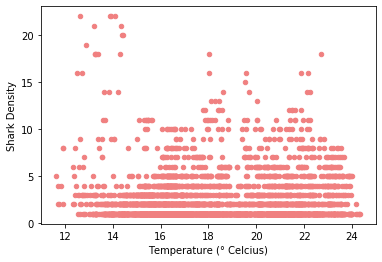

In [8]:
dat.plot(x='TempC', y='Transmitter', kind='scatter', color='lightcoral')
    # let's do a scatter plot to see if there's a linear relationship that we can see
plt.xlabel('Temperature (\N{DEGREE SIGN} Celcius)') # fix xlabel
plt.ylabel('Shark Density') # fix ylabel
plt.show() # show plot

It's no secret that this data looks very messy and would show a non-significant value if we ran a correlation test. Let's first try to figure out whether this is the true distribution of data, or whether something (like year) is influincing this relationship.

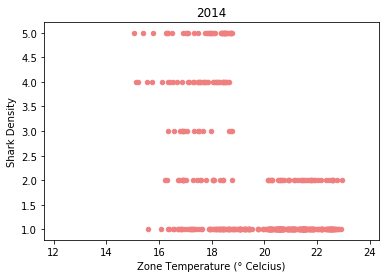

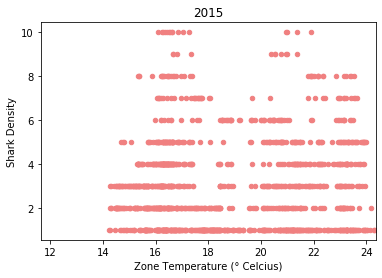

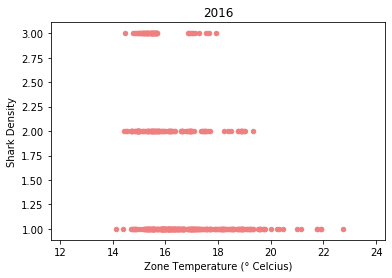

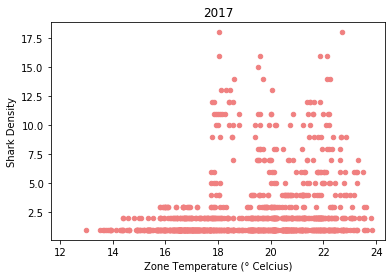

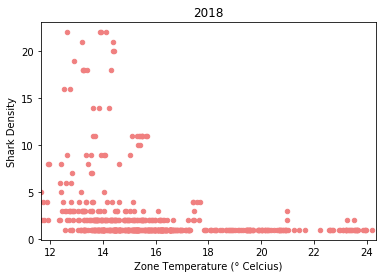

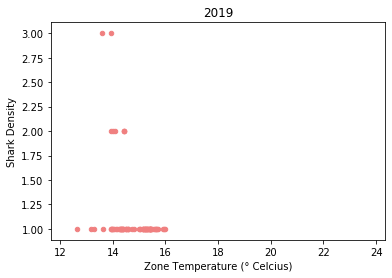

In [9]:
# Maybe the relationship is driven by different years? 
sst = dat.loc[:,['TempC', 'Transmitter', 'Year']].reset_index(drop=True)
    # let's subset the data to include temperature, shark density and year

# And we'll set up a loop so that we can plot each year on its own
for year in sst['Year'].drop_duplicates(): # for each unique year
    sst_temp = sst[sst['Year'] == year] # subset the data that has that year
    sst_temp.plot(x='TempC', y='Transmitter', title=year, xlim=(sst['TempC'].min(), 
                                                                sst['TempC'].max()), 
                  kind='scatter', color='lightcoral')
        # plot the data with the same xlims for each plot, and the title as the year
        # in question
    plt.xlabel('Zone Temperature (\N{DEGREE SIGN} Celcius)') # fix xlab
    plt.ylabel('Shark Density') # fix ylab
    plt.show() # show plot

From this, it appears that there is something that looks like a bi-annual shift where every other year, the sharks are most present in higher temperatures or lower temperatures. This is still a really messy distribution of data even across years though. Maybe we need to alter the way we look at things. What if we look at just shark presence vs shark absence, regardless of how many sharks are actually there.

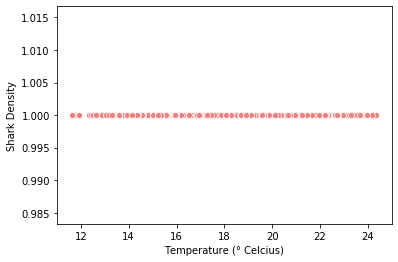

In [10]:
# Lets make a copy of dat so that we can edit the values and see what happens
shark_p = pd.DataFrame(dat, copy=True) # copy dat and save as shark_p (presence)
shark_p['Transmitter'].values[shark_p['Transmitter'].values > 1] = 1
    # any value of shark density that is > 1 is going to receiver the value 1
    
# Now, we can plot it.
sns.scatterplot(x='TempC', y='Transmitter', data=shark_p, color='lightcoral')
plt.xlabel('Temperature (\N{DEGREE SIGN} Celcius)')
plt.ylabel('Shark Density')
plt.show()

This doesn't help us at all! What if instead, we look at the highest number of sharks at each temperature value (we'll round temperatures to 0.1 degrees).

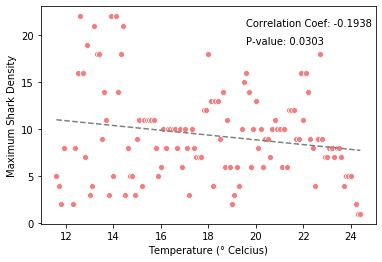

In [11]:
# First, create a copy dataset so that we can edit it without affecting the true data
rounded = pd.DataFrame(dat, copy=True) # copy

rounded['roundedTempC'] = round(rounded['TempC'], ndigits=1)
    # let's round temperature to the nearest 0.1 and add it as a new column

sst_m = rounded[['Transmitter', 'roundedTempC']].groupby('roundedTempC').agg(max).fillna(0).reset_index()
    # let's create a new dataframe that takes the relevant parameters, groups by the
    # rounded temperature, and shoots out the maximum value for that temperature
    # also, lets fill NAs and reset the index
    
# Regression line for plotting
coefs = np.polyfit(sst_m['roundedTempC'], sst_m['Transmitter'], 1)
    # We're going to be testing a correlation so let's fit a 1st order polynomial to the data
ffit = np.poly1d(coefs) # save the coefficients in 1d
x = np.linspace(sst_m['roundedTempC'].min(), sst_m['roundedTempC'].max(), 100)
    # generate x values
    
# And we'll run a correlation just in case.
ccoef = str(round(scipy.stats.pearsonr(sst_m['Transmitter'], sst_m['roundedTempC'])[0], ndigits=4))
p = str(round(scipy.stats.pearsonr(sst_m['Transmitter'], sst_m['roundedTempC'])[1], ndigits=4))

sns.scatterplot(x='roundedTempC', y='Transmitter', data=sst_m, color='lightcoral') # and plot it
plt.plot(x, ffit(x), color='gray', linestyle='dashed') # and plot the regression line
plt.text(19.6, 21, 'Correlation Coef: ' + ccoef )
plt.text(19.6, 19, 'P-value: ' + p )
plt.ylabel('Maximum Shark Density')
plt.xlabel('Temperature (\N{DEGREE SIGN} Celcius)')
plt.show()

The correlation p-value is significant (< 0.05), but the correlation coefficient is weak (-0.2). Maybe a different relationship is more suitable. It looks like there are two peaks here: one between 12 and 14 degrees and another between 18 and 22 degrees. Maybe we can model this with a polynomial?

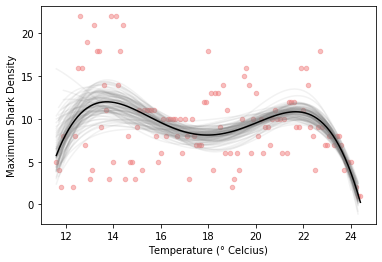

In [12]:
sst_m.plot(x='roundedTempC', y='Transmitter', kind='scatter', color='lightcoral', alpha=0.5)
    # let's replot the data so that we can overlap our model fits

# We're going to bootstrap through the data indices and build polynomial functions
# for each bootstrap. Then we're going to plot all of the fitted lines to see where
# we expect the relationship's 'bounds' are.
np.random.seed(33) # let's set a random seed for reproducibility
p_val = [] # empty list to save pvalues
for i in range(100): # for 100 iterations
    r_ind = np.random.randint(low=0, high=len(sst_m)-1, size=len(sst_m))
        # randomly sample an index between 0 and the last index value in sst_m
        # randomly sample the same number of values as is in sst_m; this is
        # sampling with replacement
    subs = sst_m.loc[r_ind,:] # now grab the sst_m values that have these
        # indices
    coefs = np.polyfit(subs['roundedTempC'], subs['Transmitter'], 4)
        # fit a 4 dregree polynomial here and save the coefficients
    ffit = np.poly1d(coefs) # now fit the coefficients into a 1d form
    x = np.linspace(subs['roundedTempC'].min(), subs['roundedTempC'].max(), 100)
        # generate 100 values for temperature between the min and the max
    plt.plot(x, ffit(x), color='gray', alpha=0.1) # and plot the fit with a 
        # transparent gray line
    results = smf.ols(formula='Transmitter ~ ffit(roundedTempC)', data=subs).fit()
        # get model results
    p_val.append(results.pvalues[1]) # save iteration pvalue

# Now, let's plot the polynomial function that we get if we use all the data
coefs = np.polyfit(sst_m['roundedTempC'], sst_m['Transmitter'], 4) 
    # fit a 4 degree polynomial here
ffit = np.poly1d(coefs) # save the coefficients into a 1d form
x = np.linspace(sst_m['roundedTempC'].min(), sst_m['roundedTempC'].max(), 100)
    # generate 100 numbers between the min and max temperature
results = smf.ols(formula='Transmitter ~ ffit(roundedTempC)', data=sst_m).fit()
    # get model results
p_val_all = results.pvalues[1] # keep main p-value
plt.plot(x, ffit(x), color='black') # add this line in black
plt.ylabel('Maximum Shark Density') # ylabel
plt.xlabel('Temperature (\N{DEGREE SIGN} Celcius)') # xlabel
plt.show()  # and show

In [13]:
# Find the average and standard deviation for p-values from bootstrap
p_val = pd.to_numeric(p_val)
print('Bootstrap p-values: ' + str(scipy.stats.describe(p_val)))
print('')

# And find the value from using all the data
print('All Data p-values: ' + str(p_val_all))

Bootstrap p-values: DescribeResult(nobs=100, minmax=(1.964757992978338e-14, 0.0016669563824429042), mean=3.05241757916945e-05, variance=2.8696844949289745e-08, skewness=9.192633200100522, kurtosis=85.91967834104088)

All Data p-values: 3.45316736676679e-07


This might fit the data quite nicely (p < 0.05). We see at the first peak, there's a bit more variation in our model runs. I think this is because the some years, the data were skewed so that more sharks were present in colder temperatures. However, we see that it does, indeed, seem to get too hot for some sharks, as temperatures increase beyond 22 degrees. 

### Shark Density vs Sea Surface Salinity

Now let's see what the relationship is between these two variables.

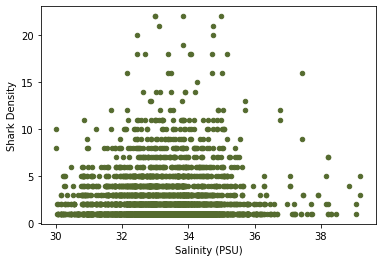

In [14]:
# Let's start by plotting it.
dat.plot(x='Sal', y='Transmitter', kind='scatter', color='darkolivegreen')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Shark Density')
plt.show()

It looks like we may have a similar issue to the one we had for sea surface temperature. We'll replot this as the maximum number of sharks at each salinity.

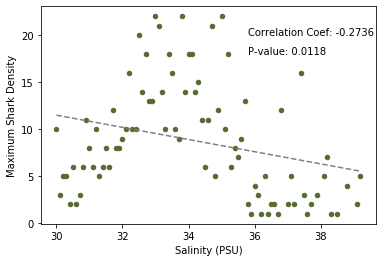

In [15]:
rounded['roundedSal'] = round(rounded['Sal'], ndigits=1) # let's add a rounded 
    # salinity value to our rounded dataset
    
sss_m = rounded[['Transmitter', 'roundedSal']].groupby('roundedSal').agg(max).fillna(0).reset_index()
    # and we'll create a new dataset that returns the largest
    # number of transmitters per salinity value
    
# Regression line for plotting
coefs = np.polyfit(sss_m['roundedSal'], sss_m['Transmitter'], 1)
    # We're going to be testing a correlation so let's fit a 1st order polynomial to the data
ffit = np.poly1d(coefs) # save the coefficients in 1d
x = np.linspace(sss_m['roundedSal'].min(), sss_m['roundedSal'].max(), 100)
    # generate x values
    
# And we'll run a correlation just in case.
ccoef = str(round(scipy.stats.pearsonr(sss_m['Transmitter'], sss_m['roundedSal'])[0], ndigits=4))
p = str(round(scipy.stats.pearsonr(sss_m['Transmitter'], sss_m['roundedSal'])[1], ndigits=4))

# Time to plot it
sss_m.plot(x='roundedSal', y='Transmitter', kind='scatter', color='darkolivegreen')
plt.plot(x, ffit(x), color='gray', linestyle='dashed') # and plot the regression line
plt.text(35.8, 20, 'Correlation Coef: ' + ccoef )
plt.text(35.8, 18, 'P-value: ' + p )
plt.xlabel('Salinity (PSU)')
plt.ylabel('Maximum Shark Density')
plt.show()

This looks a lot cleaner. We get a significant correlation p-value (< 0.05) but the correlation is still pretty weak (-0.3). I think this is because shark density appears to increase between salinitys of 20-24, then decrease for salinities greater than 34. Maybe this, too, is better plotted as a polynomial function.

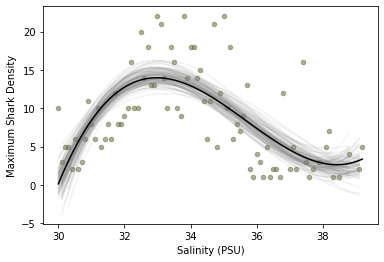

In [16]:
sss_m.plot(x='roundedSal', y='Transmitter', kind='scatter', color='darkolivegreen', 
           alpha=0.5)
    # replot the data so that we can add polynomial lines to the top
    
# Let's run a bootstrap
np.random.seed(33) # set a random seed for reproducibility
p_val = [] # set empty pval
for i in range(100): # run 100 iterations
    r_ind = np.random.randint(low=0, high=len(sss_m)-1, size=len(sss_m))
        # randomly sample indices with replacement
    subs = sss_m.loc[r_ind,:] # grab the values that were sampled
    coefs = np.polyfit(subs['roundedSal'], subs['Transmitter'], 3)
        # fit a third order polynomial to the data
    ffit = np.poly1d(coefs) # save the coefficients in 1d
    x = np.linspace(subs['roundedSal'].min(), subs['roundedSal'].max(), 100)
        # generate x values
    plt.plot(x, ffit(x), color='gray', alpha=0.1) # and plot the model fit
    results = smf.ols(formula='Transmitter ~ ffit(roundedSal)', data=subs).fit()
        # get model results
    p_val.append(results.pvalues[1]) # save iteration pvalue

# Now we'll do the same thing for all the data values
coefs = np.polyfit(sss_m['roundedSal'], sss_m['Transmitter'], 3)
    # fit a third order polynomial to the data
ffit = np.poly1d(coefs) # save the coefficients
x = np.linspace(sss_m['roundedSal'].min(), sss_m['roundedSal'].max(), 100)
    # generate x values
results = smf.ols(formula='Transmitter ~ ffit(roundedSal)', data=sss_m).fit()
    # get model results
p_val_all = results.pvalues[1] # keep main p-value
plt.plot(x, ffit(x), color='black') # add the model fit
plt.ylabel('Maximum Shark Density') # ylabel
plt.xlabel('Salinity (PSU)') # xlabel
plt.show() # show plot

In [17]:
# Find the average and standard deviation for p-values from bootstrap
p_val = pd.to_numeric(p_val)
print('Bootstrap p-values: ' + str(scipy.stats.describe(p_val)))
print('')

# And find the value from using all the data
print('All Data p-values: ' + str(p_val_all))

Bootstrap p-values: DescribeResult(nobs=100, minmax=(1.6461567305352066e-21, 1.238612463377838e-07), mean=1.8537436068204815e-09, variance=1.7105896352895864e-16, skewness=8.557258222260163, kurtosis=75.2737342753606)

All Data p-values: 6.764999589438095e-13


I think this actually fits the data quite well (p < 0.05) without overfitting the data (by increasing the order of the polynomial anymore).

### Receiver Density vs Chlorophyll-A

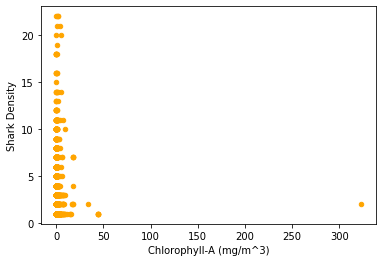

In [18]:
dat.plot(x='ChlA', y='Transmitter', color='orange', kind='scatter')
plt.xlabel('Chlorophyll-A (mg/m^3)')
plt.ylabel('Shark Density')
plt.show()

It looks like we have the same problem here - a large distribution of sharks present. Let's try the trick we did on the other environmental parameters.

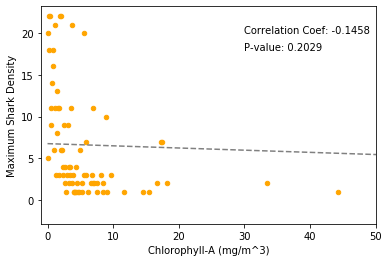

In [19]:
# Add a new column to our rounded dataset
rounded['roundedChlA'] = round(rounded['ChlA'], ndigits=1)
    # this time round chlorophyll a
    
# Build a new dataset that gives us the max # of sharks at each chlorophyll value
chla_m = rounded[['Transmitter', 'roundedChlA']].groupby('roundedChlA').agg(max).fillna(0).reset_index()

# Regression line for plotting
coefs = np.polyfit(chla_m['roundedChlA'], chla_m['Transmitter'], 1)
    # We're going to be testing a correlation so let's fit a 1st order polynomial to the data
ffit = np.poly1d(coefs) # save the coefficients in 1d
x = np.linspace(chla_m['roundedChlA'].min(), chla_m['roundedChlA'].max(), 100)
    # generate x values
    
# And we'll run a correlation just in case.
ccoef = str(round(scipy.stats.pearsonr(chla_m['Transmitter'], chla_m['roundedChlA'])[0], ndigits=4))
p = str(round(scipy.stats.pearsonr(chla_m['Transmitter'], chla_m['roundedChlA'])[1], ndigits=4))
    
# And plot the results
chla_m.plot(x='roundedChlA', y='Transmitter', xlim=(-1,50), color='orange', kind='scatter')
plt.plot(x, ffit(x), color='gray', linestyle='dashed') # and plot the regression line
plt.text(30, 20, 'Correlation Coef: ' + ccoef )
plt.text(30, 18, 'P-value: ' + p )
plt.ylabel('Maximum Shark Density')
plt.xlabel('Chlorophyll-A (mg/m^3)')
plt.show()

This didn't really seem to help our case. And the p-value for our correlation test is not significant. However, by just looking at the data, it seems like when the chlorophyll is low (close to 0), more sharks are present. Maybe we can get what we want by transforming the dataset.

C:\Users\echel\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


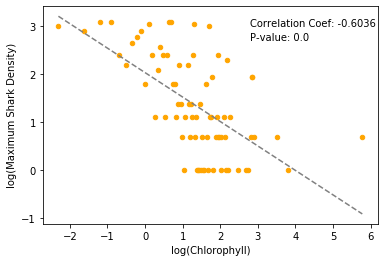

In [20]:
# We could try a log transformation
chla_m['transx'] = np.log(chla_m['roundedChlA'])
chla_m['transy'] = np.log(chla_m['Transmitter'])

# Regression line for plotting
chla_m = chla_m.replace([np.inf, -np.inf], np.nan).dropna() # remove inf values
coefs = np.polyfit(chla_m['transx'], chla_m['transy'], 1)
    # We're going to be testing a correlation so let's fit a 1st order polynomial to the data
ffit = np.poly1d(coefs) # save the coefficients in 1d
x = np.linspace(chla_m['transx'].min(), chla_m['transx'].max(), 100)
    # generate x values
    
# And we'll run a correlation just in case.
ccoef = str(round(scipy.stats.pearsonr(chla_m['transy'], chla_m['transx'])[0], ndigits=4))
p = str(round(scipy.stats.pearsonr(chla_m['transy'], chla_m['transx'])[1], ndigits=4))

chla_m.plot('transx', 'transy', color='orange', kind='scatter')
plt.plot(x, ffit(x),  color='gray', linestyle='dashed') # and plot the regression line
plt.text(2.8, 3, 'Correlation Coef: ' + ccoef )
plt.text(2.8, 2.7, 'P-value: ' + p )
plt.xlabel('log(Chlorophyll)')
plt.ylabel('log(Maximum Shark Density)')
plt.show()

This looks good. The p value for the correlation is significant (< 0.05) and there is a strong negative relationship (-0.6). So this means that the variables respond to each other logarithmically.

### Shark Density vs Depth Gradient

The depth gradient is how steep the seafloor is in a particular area. One would think that maybe flat areas are more appealing to younger sharks who are still learning to hunt, while steeper areas may be more useful for adult sharks who are trying to ambush their prey.

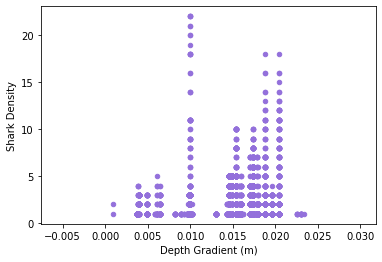

In [21]:
# Start by plotting the data.
dat.plot(x='DepthGradient', y='Transmitter', kind='scatter', color='mediumpurple')
plt.xlabel('Depth Gradient (m)')
plt.ylabel('Shark Density')
plt.show()

This looks more lie a histogram than a distribution of data. And the values for the depth gradient seem to be very small (most of the seafloor appears to be relatively flat). I don't know if we have a wide enough spread of these data values to really be able to tell whether these juvenile white sharks have a preference. Anyway, let's see how the data respond to our previous methods of grabbing the largest number of sharks present per value.

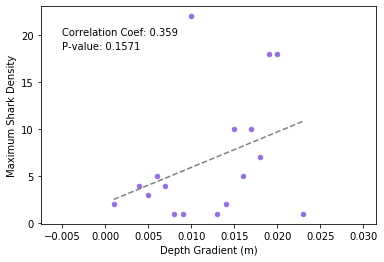

In [22]:
# We'll add rounded depth gradient to the rounded dataset
rounded['roundedD'] = round(rounded['DepthGradient'], ndigits=3)
    # notice that we've added more rounding digits because the data
    # are not very spread out.

# Create a new dataset with the maximum number of sharks per each value
dep = rounded[['Transmitter', 'roundedD']].groupby('roundedD').agg(max).reset_index()

# Regression line for plotting
coefs = np.polyfit(dep['roundedD'], dep['Transmitter'], 1)
    # We're going to be testing a correlation so let's fit a 1st order polynomial to the data
ffit = np.poly1d(coefs) # save the coefficients in 1d
x = np.linspace(dep['roundedD'].min(), dep['roundedD'].max(), 100)
    # generate x values
    
# And we'll run a correlation just in case.
ccoef = str(round(scipy.stats.pearsonr(dep['Transmitter'], dep['roundedD'])[0], ndigits=4))
p = str(round(scipy.stats.pearsonr(dep['Transmitter'], dep['roundedD'])[1], ndigits=4))

# And plot the data
dep.plot(x='roundedD', y='Transmitter', kind='scatter', color='mediumpurple')
plt.plot(x, ffit(x),  color='gray', linestyle='dashed') # and plot the regression line
plt.text(-0.005, 20, 'Correlation Coef: ' + ccoef )
plt.text(-0.005, 18.5, 'P-value: ' + p )
plt.ylabel('Maximum Shark Density')
plt.xlabel('Depth Gradient (m)')
plt.show()

I don't think that this regression line fits the data very well. Let's try to see if maybe a transformation will help to make things a little bit more clear.

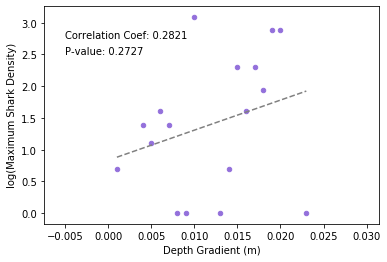

In [23]:
# Let's take the log of the y value
dep['transy'] = np.log(dep['Transmitter'])

# Regression line for plotting
dep = dep.replace([np.inf, -np.inf], np.nan).dropna()
coefs = np.polyfit(dep['roundedD'], dep['transy'], 1)
    # We're going to be testing a correlation so let's fit a 1st order polynomial to the data
ffit = np.poly1d(coefs) # save the coefficients in 1d
x = np.linspace(dep['roundedD'].min(), dep['roundedD'].max(), 100)
    # generate x values
    
# And we'll run a correlation just in case.
ccoef = str(round(scipy.stats.pearsonr(dep['transy'], dep['roundedD'])[0], ndigits=4))
p = str(round(scipy.stats.pearsonr(dep['transy'], dep['roundedD'])[1], ndigits=4))

# And plot the data
dep.plot(x='roundedD', y='transy', kind='scatter', color='mediumpurple')
plt.plot(x, ffit(x),  color='gray', linestyle='dashed') # and plot the regression line
plt.text(-0.005, 2.75, 'Correlation Coef: ' + ccoef )
plt.text(-0.005, 2.5, 'P-value: ' + p )
plt.ylabel('log(Maximum Shark Density)')
plt.xlabel('Depth Gradient (m)')
plt.show()

Here, we have the same problem; there doesn't really seem to be any correlation. Maybe we just don't have a wide enough spread of data. Maybe we shouldn't even include this in the final model.

### Shark Density vs Lunar Phase

Many animal movements correspond to different phases of the lunar cycle. Let's see if that's the case here.

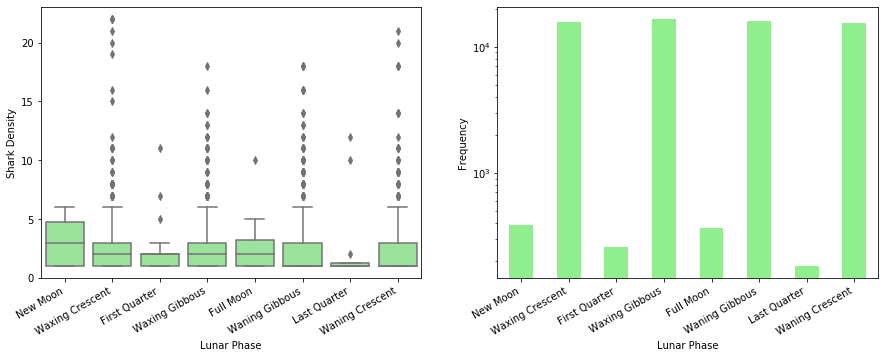

In [24]:
# Plot the data
%matplotlib inline 

col_order = ['NEW_MOON', 'WAXING_CRESCENT', 'FIRST_QUARTER', 'WAXING_GIBBOUS', 
             'FULL_MOON', 'WANING_GIBBOUS', 'LAST_QUARTER', 'WANING_CRESCENT']
    # I want the data to be plotted in the order of the lunar cycle. 

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5)) # we're going to make
    # a two panel figure so that we can display the relationship and the underlying
    # distribution of data. 
    
# Begin the boxplot
sns.boxplot(x='MoonPhase', y='Transmitter', data=dat, color='lightgreen', 
            order=col_order, ax=ax1)
ax1.set_xlabel('Lunar Phase')
ax1.set_xticklabels(['New Moon', 'Waxing Crescent', 'First Quarter', 
                                    'Waxing Gibbous', 'Full Moon', 'Waning Gibbous',
                                    'Last Quarter', 'Waning Crescent'], 
           rotation=30, horizontalalignment ='right')
    # I want the xticks to look nicer (not uppercase text with _) and easier to read (rotated)
ax1.set_ylabel('Shark Density') # ylabel

# We should also plot the distribution for reference
l_counts = pd.DataFrame(dist_plot_data['MoonPhase'].value_counts()).reindex(col_order)
    # get value counts for each phase and reset the index
l_counts.columns = ['Frequency'] # rename the columns
l_counts.plot.bar(y='Frequency', logy=True, color='lightgreen', 
                  legend=False, ax=ax2, rot=45) # plot on the logy scale
ax2.set_xticklabels(['New Moon', 'Waxing Crescent', 'First Quarter', 
                                    'Waxing Gibbous', 'Full Moon', 'Waning Gibbous',
                                    'Last Quarter', 'Waning Crescent'], 
           rotation=30, horizontalalignment ='right')
ax2.set_xlabel('Lunar Phase') # label the x
ax2.set_ylabel('Frequency') # label the y
plt.show() # show the plot

plt.show() # show plot

It looks like, in general, all the lunar phases have somewhat similar distributions of data. Let's perform an ANOVA to see if this is truly the case.

In [25]:
# Set up a new dataset for the data to run in the ANOVA
lunar = dat.loc[:,['MoonPhase', 'Transmitter']].reset_index(drop=True)

phaselist = list(lunar.MoonPhase.drop_duplicates().sort_values())
    # there's too many phases to list by hand, so we will just generate
    # the list and sort it alphabetically (that's how get_dummies)
    # sorts it

lunar.loc[:,'intercept'] = 1 # add an intercept to our data

lunar[phaselist] = pd.get_dummies(lunar.loc[:,'MoonPhase'])
    # and get the dummy matrix going for the different lunar phases

int_list = ['intercept'] # we want to add the value 'intercept' to the list
int_list.extend(phaselist[1:]) # add the other phases at the end
    
# Run the OLS
lunar_ols = sm.OLS(lunar.loc[:,'Transmitter'],lunar.loc[:,int_list])
results_lunar = lunar_ols.fit() # and save the results

In [26]:
# Print the results
results_lunar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transmitter   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4692
Date:                Mon, 16 Dec 2019   Prob (F-statistic):              0.857
Time:                        10:55:43   Log-Likelihood:                -9368.4
No. Observations:                4042   AIC:                         1.875e+04
Df Residuals:                    4034   BIC:                         1.880e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           2.3043      0.513      4.494      0.000       1.299       3.310
FULL_MOON           0.3457      0.752      0.460      0.646      -1.128       1.820
LAST_QUARTER        0.4457      0.876      0.509      0.611      -1.271       2.163
NEW_MOON            0.6572      0.704      0.934      0.351      -0.723       2.037
WANING_CRESCENT     0.0779      0.519      0.150      0.881      -0.940       1.095
WANING_GIBBOUS      0.2207      0.519      0.425      0.671      -0.796       1.238
WAXING_CRESCENT     0.1835      0.519      0.354      0.724      -0.834       1.200
WAXING_GIBBOUS      0.2013      0.518      0.388      0.698      -0.815       1.217
==============================================================================
Omnibus:                     2681.092   Durbin-Watson:                   1.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35752.677
Skew:                           3.037   Prob(JB):                         0.00
Kurtosis:                      16.244   Cond. No.                         43.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It seems like there's no significant difference in shark density across the different lunar cycles.

### Shark Density vs Zone ID

The last thing we should look at is whether particular zones tend to have more or less sharks. Zones are categories, so we'll do a boxplot and an ANOVA.

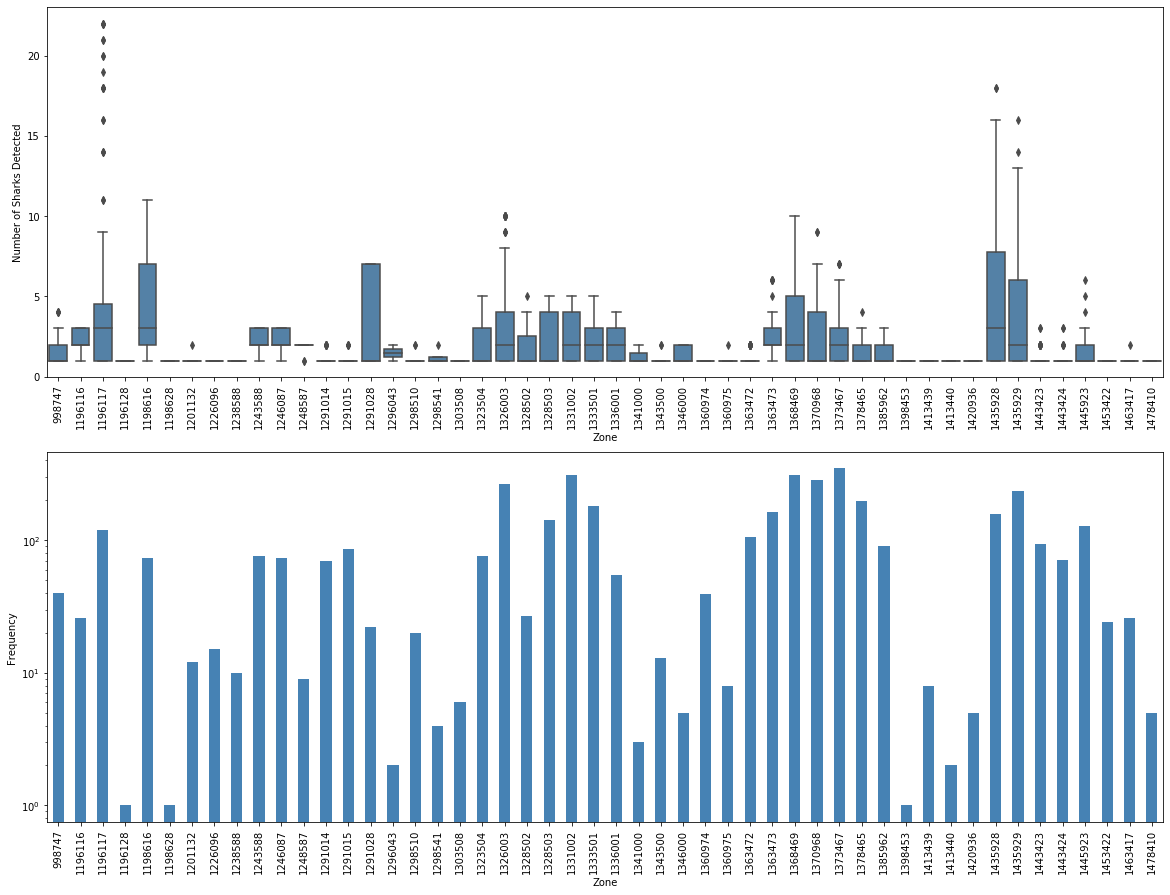

In [27]:
# Make a nice long plot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,15)) # we're going to make
    # a two panel figure so that we can display the relationship and the underlying
    # distribution of data. 
sns.boxplot(x='Zone', y='Transmitter', data=dat, ax=ax1, color='steelblue')
ax1.set_xlabel('Zone')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90) # rotate the xaxis
ax1.set_ylabel('Number of Sharks Detected')
#plt.show()

# We should also plot the distribution  for reference
z_counts = pd.DataFrame(dat['Zone'].value_counts()).reindex(list(dat['Zone'].drop_duplicates().sort_values().reset_index(drop=True)))
    # get value counts for each and reset the index
z_counts.columns = ['Frequency'] # rename the columns
z_counts.plot.bar( y='Frequency', logy=True, color='steelblue', 
                  legend=False, rot=90, ax=ax2) # plot on the logy scale
ax2.set_xlabel('Zone') # label the x
ax2.set_ylabel('Frequency') # label the y
plt.show() # show the plot

It does look like some of theze sones have higher values than others. Let's see what the ANOVA says.

In [28]:
# Create our own new dataset
zones = dat.loc[:,['Zone', 'Transmitter']]

# There are so many zones we want to come up with our own sorted list
zonelist = list(zones.Zone.drop_duplicates().sort_values())

zones.loc[:, 'intercept'] = 1 # set the null intercept

zones[zonelist] = pd.get_dummies(zones['Zone']) # and set up the dummy matrix

int_list = ['intercept'] # create a new list with the intercept
int_list.extend(zonelist[1:]) # and add the zone list to it

zone_ols = sm.OLS(zones['Transmitter'],zones[int_list])
    # run the OLS
results_zone = zone_ols.fit() # and get the fit

In [29]:
# Finally, get the results
results_zone.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transmitter   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     19.17
Date:                Mon, 16 Dec 2019   Prob (F-statistic):          2.97e-146
Time:                        10:55:45   Log-Likelihood:                -8943.1
No. Observations:                4042   AIC:                         1.799e+04
Df Residuals:                    3992   BIC:                         1.830e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8000      0.352      5.116      0.000       1.110       2.490
1196116        0.3538      0.561      0.631      0.528      -0.745       1.453
1196117        3.4185      0.407      8.406      0.000       2.621       4.216
1196128       -0.8000      2.253     -0.355      0.723      -5.217       3.617
1198616        2.6110      0.438      5.965      0.000       1.753       3.469
1198628       -0.8000      2.253     -0.355      0.723      -5.217       3.617
1201132       -0.7167      0.732     -0.979      0.328      -2.153       0.719
1226096       -0.8000      0.674     -1.187      0.235      -2.121       0.521
1238588       -0.8000      0.787     -1.017      0.309      -2.342       0.742
1243588        0.4368      0.435      1.005      0.315      -0.415       1.289
1246087        0.5378      0.437      1.232      0.218      -0.318       1.394
1248587       -0.0222      0.821     -0.027      0.978      -1.632       1.587
1291014       -0.6714      0.441     -1.522      0.128      -1.536       0.193
1291015       -0.7419      0.426     -1.742      0.082      -1.577       0.093
1291028        1.4273      0.591      2.417      0.016       0.269       2.585
1296043       -0.3000      1.612     -0.186      0.852      -3.461       2.861
1298510       -0.7000      0.609     -1.149      0.251      -1.895       0.495
1298541       -0.5500      1.167     -0.471      0.637      -2.838       1.738
1303508       -0.8000      0.974     -0.821      0.412      -2.710       1.110
1323504        0.2526      0.435      0.581      0.561      -0.600       1.105
1326003        1.4970      0.377      3.967      0.000       0.757       2.237
1328502        0.0519      0.554      0.094      0.925      -1.035       1.138
1328503        0.2775      0.398      0.697      0.486      -0.503       1.058
1331002        0.6613      0.374      1.769      0.077      -0.072       1.394
1333501        0.3333      0.389      0.857      0.392      -0.429       1.096
1336001        0.0727      0.462      0.157      0.875      -0.834       0.979
1341000       -0.4667      1.332     -0.350      0.726      -3.078       2.145
1343500       -0.6462      0.710     -0.910      0.363      -2.039       0.747
1346000       -0.4000      1.055     -0.379      0.705      -2.469       1.669
1360974       -0.8000      0.501     -1.598      0.110      -1.782       0.182
1360975       -0.6750      0.862     -0.783      0.434      -2.365       1.015
1363472       -0.6095      0.413     -1.474      0.140      -1.420       0.201
1363473        0.7521      0.393      1.916      0.055      -0.018       1.522
1368469        1.5701      0.374      4.199      0.000       0.837       2.303
1370968        0.8021      0.376      2.134      0.033       0.065       1.539
1373467        0.3034      0.371      0.817      0.414      -0.425       1.032
13

In [30]:
# Ok so which of these are actually significant?
sigs = pd.DataFrame(results_zone.params[results_zone.pvalues < 0.05]) 
sigs.columns = ['ParameterEstimate']
sigs['p'] = (results_zone.pvalues[results_zone.pvalues < 0.05]) 
print(sigs)

           ParameterEstimate             p
intercept           1.800000  3.264356e-07
1196117             3.418487  5.835554e-17
1198616             2.610959  2.661809e-09
1291028             1.427273  1.571286e-02
1326003             1.496992  7.402844e-05
1368469             1.570130  2.745355e-05
1370968             0.802113  3.286279e-02
1435928             3.098734  4.611650e-15
1435929             1.900422  6.090908e-07


This table is pretty beefy, because there are so many different zones. However, it looks like ~8 zones have significantly different shark densities compared to their other counterparts. Looking at the printout, it also appears that a lot of these zones are close to one another. My guess is that zones with higher estimated parameters represent 'hotspot' beaches where juvenile white sharks have spent their time in the past.